## Mount Drive to access PDF files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install and import needed libraries

In [ ]:
!pip install pdfplumber

In [3]:
import pandas as pd
import numpy as np
import pdfplumber

In [5]:
pdf_file_path = "drive/MyDrive/Colab_Notebooks/PDF_Scraping/INSEED_September_2023-6.pdf"

## Load the file in pdfplumber

In [ ]:
# You can just do this : pdf = pdfplumber.open(pdf_file_path)
with pdfplumber.open(pdf_file_path) as pdf:
    first_page = pdf.pages[0]
    rows = first_page.extract_text().split('\n')
rows[2:52]

## Let's view the image, checking to see how it has identified the various word in the page

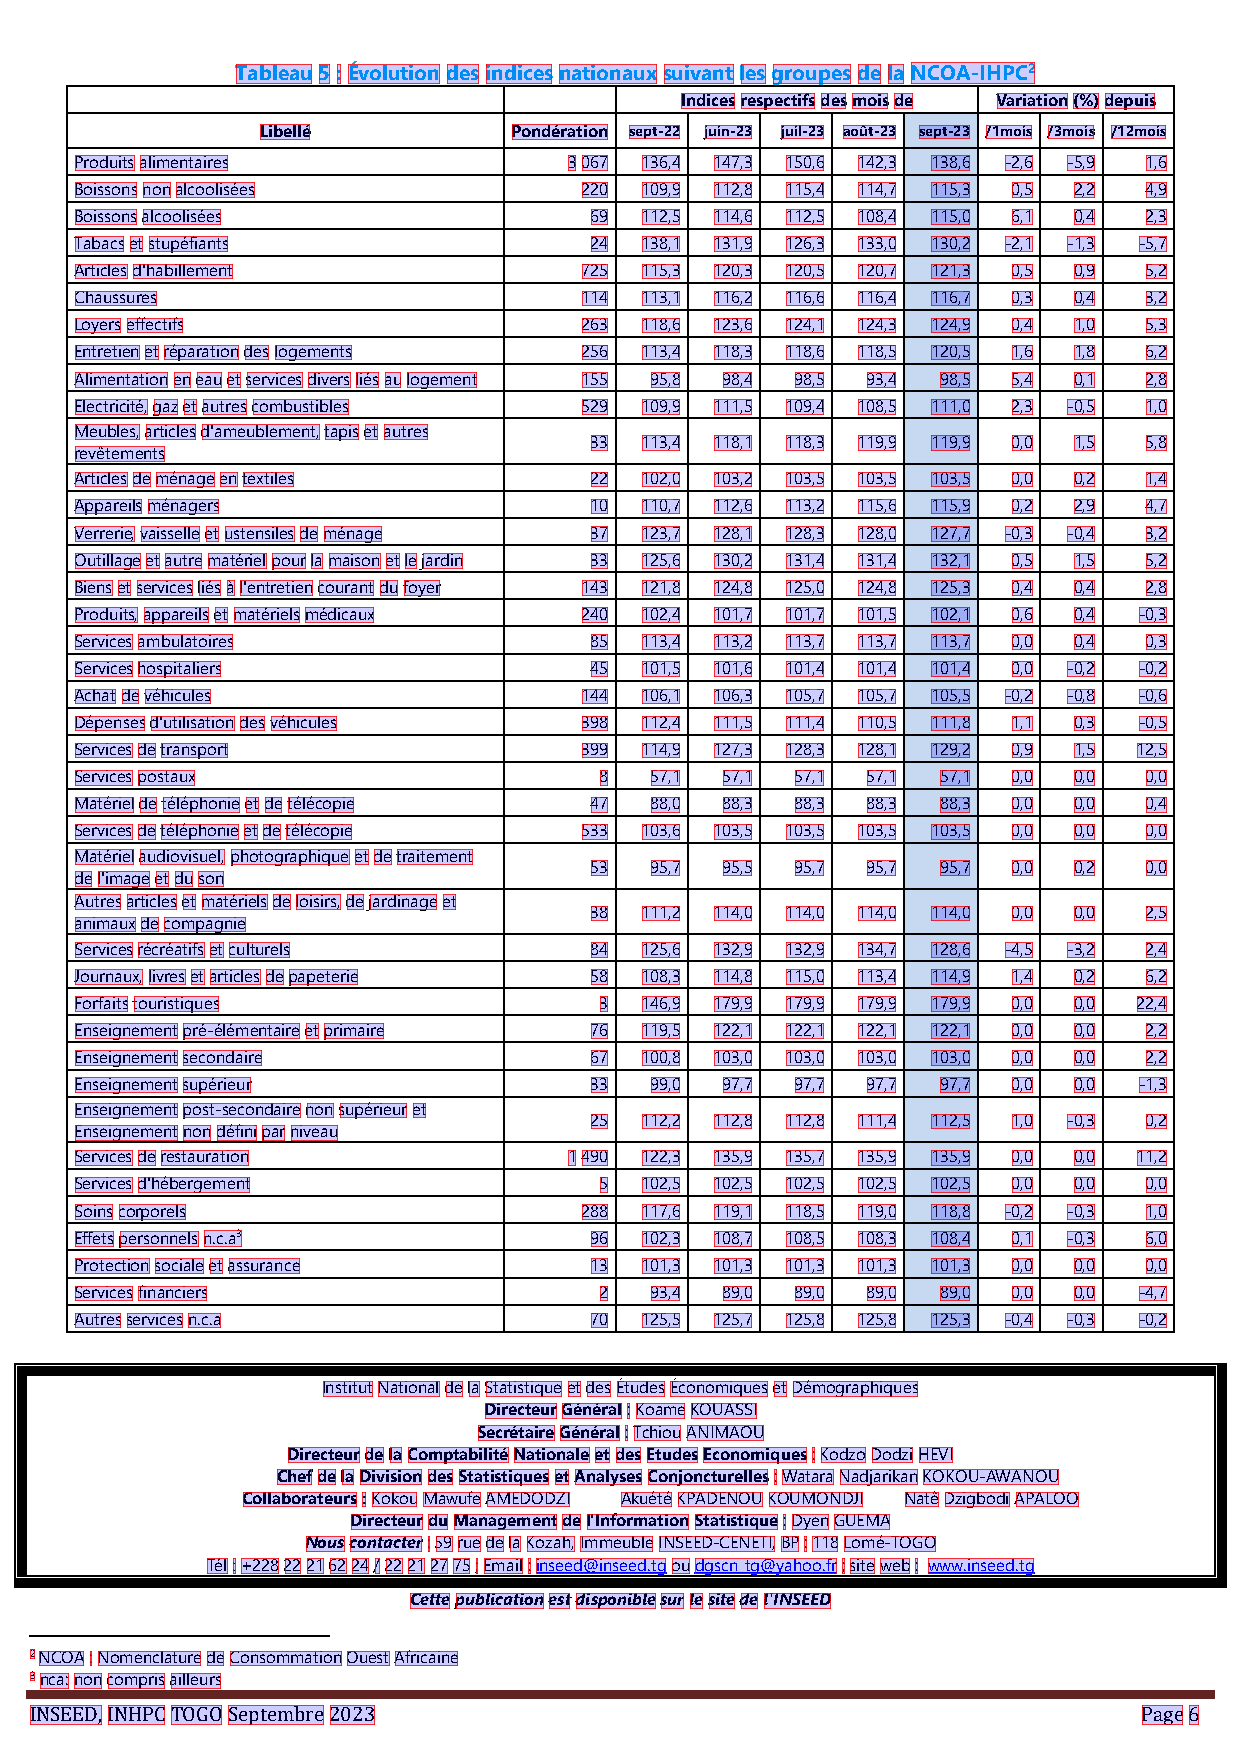

In [ ]:
first_page.to_image(resolution=150).outline_words()

## Crop the Main Table

In [12]:
with pdfplumber.open(pdf_file_path) as pdf:
    first_page = pdf.pages[0]
    rows = first_page.extract_words()

for row in rows:
    if row['text'] == 'Libellé':
        x0 = row['x0']
        top = row['top']
    if row['text'] == 'n.c.a':
        bottom = row['bottom']
    if row['text'] == '/12mois':
        x1 = row['x1']

box = (x0 - 90, top, x1, bottom) # Petit décalage à gauche au niveau du Libellé
box

(34.58, 59.288400000000024, 559.696, 637.4284)

In [13]:
table_settings = {
    "vertical_strategy": "lines",
    "horizontal_strategy": "lines",
    "snap_tolerance": 3,
    "join_tolerance": 3,
}
# Now we can crop the page starting with Name/Company for our upper and left bound, to right of 'ST' and bottom of "Watson"
with pdfplumber.open(pdf_file_path) as pdf:
    first_page = pdf.pages[0]
    page = first_page.crop(bbox=(box))  # (x0, top, x1, bottom)
    table = page.extract_table(table_settings)


In [14]:
# Let's take a look at the cropped table
pdf_image = page.to_image(resolution=150)

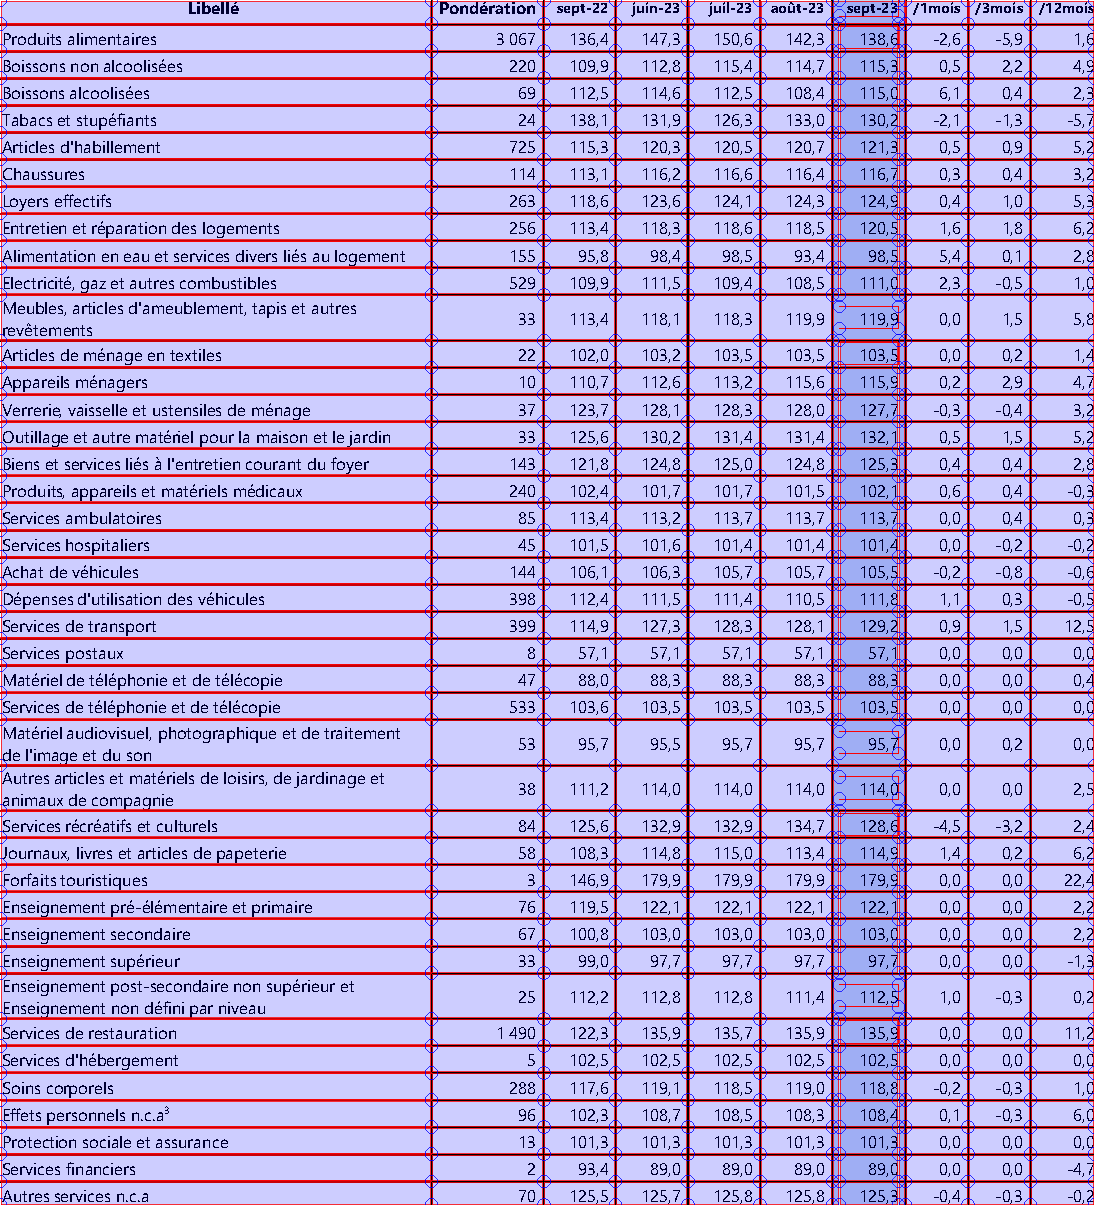

In [15]:
pdf_image.debug_tablefinder()

In [19]:
# Ok- let's see how this is looking data-wise
for row in table[2:60]:
    print(row)

['Boissons non alcoolisées', '220', '109,9', '112,8', '115,4', '114,7', '', '115,3', '', '0,5', '2,2', '4,9']
['Boissons alcoolisées', '69', '112,5', '114,6', '112,5', '108,4', '', '115,0', '', '6,1', '0,4', '2,3']
['Tabacs et stupéfiants', '24', '138,1', '131,9', '126,3', '133,0', '', '130,2', '', '-2,1', '-1,3', '-5,7']
["Articles d'habillement", '725', '115,3', '120,3', '120,5', '120,7', '', '121,3', '', '0,5', '0,9', '5,2']
['Chaussures', '114', '113,1', '116,2', '116,6', '116,4', '', '116,7', '', '0,3', '0,4', '3,2']
['Loyers effectifs', '263', '118,6', '123,6', '124,1', '124,3', '', '124,9', '', '0,4', '1,0', '5,3']
['Entretien et réparation des logements', '256', '113,4', '118,3', '118,6', '118,5', '', '120,5', '', '1,6', '1,8', '6,2']
['Alimentation en eau et services divers liés au logement', '155', '95,8', '98,4', '98,5', '93,4', '', '98,5', '', '5,4', '0,1', '2,8']
['Electricité, gaz et autres combustibles', '529', '109,9', '111,5', '109,4', '108,5', '', '111,0', '', '2,3', 

## Cleaning table

In [20]:
# Fis the blank rows by including only those rows that do not all equal blank strings
table = [row for row in table if ''.join([str(i) for i in row]) != '']

## Load into a dataframe and view the first five rows

In [23]:
df = pd.DataFrame(table)
df.head(30)

,0,1,2,3,4,5,6,7,8,9,10,11
0,Libellé,Pondération,sept-22,juin-23,juil-23,août-23,sept-23,None,None,/1mois,/3mois,/12mois
1,Produits alimentaires,3 067,"136,4","147,3","150,6","142,3",,"138,6",,"-2,6","-5,9","1,6"
2,Boissons non alcoolisées,220,"109,9","112,8","115,4","114,7",,"115,3",,"0,5","2,2","4,9"
3,Boissons alcoolisées,69,"112,5","114,6","112,5","108,4",,"115,0",,"6,1","0,4","2,3"
4,Tabacs et stupéfiants,24,"138,1","131,9","126,3","133,0",,"130,2",,"-2,1","-1,3","-5,7"
5,Articles d'habillement,725,"115,3","120,3","120,5","120,7",,"121,3",,"0,5","0,9","5,2"
6,Chaussures,114,"113,1","116,2","116,6","116,4",,"116,7",,"0,3","0,4","3,2"
7,Loyers effectifs,263,"118,6","123,6","124,1","124,3",,"124,9",,"0,4","1,0","5,3"
8,Entretien et réparation des logements,256,"113,4","118,3","118,6","118,5",,"120,5",,"1,6","1,8","6,2"
9,Alimentation en eau et services divers liés au...,155,"95,8","98,4","98,5","93,4",,"98,5",,"5,4","0,1","2,8"


## Delete columns containing only null values

In [28]:
df = df.replace('', None)
df = df.dropna(axis=1, how='all')

In [29]:
df[6] = df[6].combine_first(df[7])
df.drop(7, axis=1, inplace=True)

,0,1,2,3,4,5,6,9,10,11
0,Libellé,Pondération,sept-22,juin-23,juil-23,août-23,sept-23,/1mois,/3mois,/12mois
1,Produits alimentaires,3 067,"136,4","147,3","150,6","142,3","138,6","-2,6","-5,9","1,6"
2,Boissons non alcoolisées,220,"109,9","112,8","115,4","114,7","115,3","0,5","2,2","4,9"
3,Boissons alcoolisées,69,"112,5","114,6","112,5","108,4","115,0","6,1","0,4","2,3"
4,Tabacs et stupéfiants,24,"138,1","131,9","126,3","133,0","130,2","-2,1","-1,3","-5,7"
5,Articles d'habillement,725,"115,3","120,3","120,5","120,7","121,3","0,5","0,9","5,2"
6,Chaussures,114,"113,1","116,2","116,6","116,4","116,7","0,3","0,4","3,2"
7,Loyers effectifs,263,"118,6","123,6","124,1","124,3","124,9","0,4","1,0","5,3"
8,Entretien et réparation des logements,256,"113,4","118,3","118,6","118,5","120,5","1,6","1,8","6,2"
9,Alimentation en eau et services divers liés au...,155,"95,8","98,4","98,5","93,4","98,5","5,4","0,1","2,8"


## Define DataFrame header and drop the first row.

In [30]:
df.columns = df.iloc[0]
df = df.drop(0)

df

,Libellé,Pondération,sept-22,juin-23,juil-23,août-23,sept-23,/1mois,/3mois,/12mois
1,Produits alimentaires,3 067,"136,4","147,3","150,6","142,3","138,6","-2,6","-5,9","1,6"
2,Boissons non alcoolisées,220,"109,9","112,8","115,4","114,7","115,3","0,5","2,2","4,9"
3,Boissons alcoolisées,69,"112,5","114,6","112,5","108,4","115,0","6,1","0,4","2,3"
4,Tabacs et stupéfiants,24,"138,1","131,9","126,3","133,0","130,2","-2,1","-1,3","-5,7"
5,Articles d'habillement,725,"115,3","120,3","120,5","120,7","121,3","0,5","0,9","5,2"
6,Chaussures,114,"113,1","116,2","116,6","116,4","116,7","0,3","0,4","3,2"
7,Loyers effectifs,263,"118,6","123,6","124,1","124,3","124,9","0,4","1,0","5,3"
8,Entretien et réparation des logements,256,"113,4","118,3","118,6","118,5","120,5","1,6","1,8","6,2"
9,Alimentation en eau et services divers liés au...,155,"95,8","98,4","98,5","93,4","98,5","5,4","0,1","2,8"
10,"Electricité, gaz et autres combustibles",529,"109,9","111,5","109,4","108,5","111,0","2,3","-0,5","1,0"


In [31]:
df.to_csv('output.csv')

In [32]:
pdf.close()